In [1]:
# import os
# #rename physiq filenames:
# folder = "datasets/physiq_copy/segment_sessions_one_repetition_data_E4/"
# filelabels = []
# for filename in os.listdir(folder):
#     if filename.endswith(".csv"):
#         filelist = filename.split("_")
#         if filelist[3] not in filelabels:
#             filelabels.append(filelist[3])
#         # filelist.pop(3) 
# # sort the list:
# filelabels.sort()
# for filename in os.listdir(folder):
#     if filename.endswith(".csv"):
#         filelist = list(filename.split("_"))
#         print(filelist)
#         filelist[1] = str(filelabels.index(filelist[3]))
#         filelist.pop(3)
#         filelist.pop(3)
#         newname = "_".join(filelist)
#         print(filelist, newname)
#         os.rename(folder+filename, folder+newname)


In [2]:
from utilities import *
# sw = sliding_windows(100, 50)

In [3]:
import os
import random
import pandas as pd
import numpy as np
import torch

def list_files(directory):
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

def parse_filename(filename):
    parts = filename.split('_')
    return {'subject': parts[0], 'exercise': parts[1], 'hand': parts[2], 'rep': int(parts[3].split('.')[0])}

def group_files(files):
    groups = {}
    for file in files:
        if file.endswith('.csv'):
            info = parse_filename(file)
            key = (info['subject'], info['hand'])
            if key not in groups:
                groups[key] = []
            groups[key].append(file)
    return groups

def generate_combinations(group, combo, num_results):
    all_exercises = list(set(f.split('_')[1] for f in group))
    combinations = []
    labels = []
    for _ in range(num_results):
        # Determine a random length for the combination
        combo_length = len(combo)
        max_length = max(combo_length * 3, len(all_exercises))
        random_length = random.randint(combo_length, max_length)
        # Create a random combination of exercises
        random_exercises = random.choices(all_exercises, k=random_length)
        random_labels = [0] * len(random_exercises)
        # Insert the combo at a random position
        #NOTE: currently it is only insert once.
        insert_point = random.randint(0, len(random_exercises) - combo_length)
        for i, exercise in enumerate(combo):
            random_exercises.insert(insert_point + i, exercise)
            random_labels.insert(insert_point +i , 1)
        combinations.append(random_exercises)
        labels.append(random_labels)

    return combinations, labels


def concatenate_data(directory, group, order, label=None):
    concatenated_df = pd.DataFrame()
    concatenated_label = []
    for i, exercise in enumerate(order):
        matching_files = [f for f in group if f.split('_')[1] == exercise]
        file = matching_files[random.randint(0, len(matching_files))-1] # randomly pick one file 
        df = pd.read_csv(os.path.join(directory, file))
        concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)
        if label != None:
            concatenated_label.extend([label[i]] * len(df))
    return concatenated_df.to_numpy()[:, 1:7], np.array(concatenated_label)

def generate_data(num_results, directory, combo, window_size=75, step_size=75):
    from utilities import sliding_windows
    sw = sliding_windows(window_size, step_size)
    files = list_files(directory)
    groups = group_files(files)
    # randomly pick one group from the dic:
    key = random.choice(list(groups.keys()))
    group = groups[key]
    combinations,labels = generate_combinations(group, combo, num_results)
    # print(combinations)


    segmented_samples = []
    segmented_labels = []
    for i, (order, label) in enumerate(zip(combinations, labels)):
        # print('length', len(order), order, label)
        concatenated_np, concat_label = concatenate_data(directory, group, order, label=label)
        conc_data = torch.tensor(concatenated_np)
        conc_label = torch.tensor(concat_label)
        segmented_sample, segmneted_label  = sw.forward(conc_data, conc_label)
        segmented_samples.append(segmented_sample)
        segmented_labels.append(segmneted_label)

    segmented_samples = torch.cat(segmented_samples)
    segmented_labels = torch.cat(segmented_labels)
    return segmented_samples, segmented_labels



In [4]:
# custom Dataset:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx]), self.label[idx]
        return self.data[idx], self.label[idx]

In [5]:
from utils_loader import MultiEpochsDataLoader
from sklearn.discriminant_analysis import StandardScaler
import torch

class StandardTransform(torch.nn.Module):
    def __init__(self, scaler='standard'):
        super(StandardTransform, self).__init__()
        if scaler == 'standard':
            self.scaler = StandardScaler()
        else:
            raise NotImplementedError('Only standard scaler is implemented')
        
    def __call__(self, data):
        data = self.scaler.transform(data)
        return torch.tensor(data)
    
    def fit(self, data):
        n_samples, n_time_steps, n_features = data.shape
        data_reshaped = data.reshape(-1, n_features)  # The shape becomes (n_samples * n_time_steps, n_features)
        self.scaler.fit(data_reshaped)
        print('Fitted with mean: {}, and std: {}'.format(self.scaler.mean_, np.sqrt(self.scaler.var_)))
        return self
    

seed(73054772)
directory = './datasets/spar'
combo = ['E1', 'E2']
num_results = 5000  # Number of random combinations to generate

segmented_samples, segmented_labels = generate_data(num_results, directory, combo, 75, 32)
ST = StandardTransform().fit(segmented_samples)
train_dataset = CustomDataset(segmented_samples, segmented_labels, transform=ST)
train_loader = MultiEpochsDataLoader(train_dataset, batch_size=128, shuffle=True)

val_segmented_samples, val_segmented_labels = generate_data(750, directory, combo, 75, 75)
val_dataset = CustomDataset(val_segmented_samples, val_segmented_labels, transform=ST)
val_loader = DataLoader(val_dataset, batch_size=len(val_segmented_samples), shuffle=True)

test_segmented_samples, test_segmented_labels = generate_data(750, directory, combo, 75, 75)
test_dataset = CustomDataset(test_segmented_samples, test_segmented_labels, transform=ST)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# # create train, val, test dataset:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(segmented_samples, segmented_labels, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# train_dataset = CustomDataset(X_train, y_train)
# val_dataset = CustomDataset(X_val, y_val)
# test_dataset = CustomDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Fitted with mean: [ 0.42629639  0.26867463 -0.26549961 -0.0736936   0.00968049  0.07795445], and std: [0.6268685  0.59952455 0.57129924 0.81007607 2.30593957 1.57004814]


In [6]:
# model:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
from utilities import *
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
num_epochs = 100

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=6, hidden_size=1024, num_layers=2, output_size=18):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
import torch.nn.functional as F
import math 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleList

from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer


class SimpleSegmenterMaskTransformer(nn.Module):
    def __init__(self, in_channels=6, num_layers=2, num_heads=4, embed_dims=64, **kwargs):
        super(SimpleSegmenterMaskTransformer, self).__init__(**kwargs)

        # Fixed parameters for simplicity
        mlp_ratio = 4
        # norm_cfg = dict(type='LN')
        # act_cfg = dict(type='GELU')
        self.init_std = 0.02
        self.num_classes = 2
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            layer = nn.TransformerEncoderLayer(
                d_model=embed_dims,
                nhead=num_heads,
                dim_feedforward=mlp_ratio * embed_dims,
                dropout=0.5,
                activation=F.gelu,
                layer_norm_eps=1e-05,
                batch_first=True,
                norm_first=False,
                bias=True
            )
            self.layers.append(layer)

        self.dec_proj = nn.Linear(in_channels, embed_dims)
        self.cls_emb = nn.Parameter(torch.randn(1, self.num_classes, embed_dims))
        self.patch_proj = nn.Linear(embed_dims, embed_dims, bias=False)
        self.classes_proj = nn.Linear(embed_dims, embed_dims, bias=False)
        self.decoder_norm = nn.LayerNorm(embed_dims)
        self.mask_norm = nn.LayerNorm(self.num_classes)

    # def init_weights(self):
    #     nn.init.trunc_normal_(self.cls_emb, std=self.init_std)
    #     nn.init.trunc_normal_(self.patch_proj.weight, std=self.init_std)
    #     nn.init.trunc_normal_(self.classes_proj.weight, std=init_std)
    #     for layer in self.layers:
    #         layer.init_weights()

    def forward(self, inputs):
        x = inputs.permute(0, 2, 1) # b h c
        b, c, h = x.shape
        x = x.view(b, c, -1).permute(0, 2, 1)

        x = self.dec_proj(x)
        cls_emb = self.cls_emb.expand(x.size(0), -1, -1)
        x = torch.cat((x, cls_emb), 1)
        for layer in self.layers: 
            x = layer(x)
        x = self.decoder_norm(x)

        patches = self.patch_proj(x[:, :-self.num_classes])
        cls_seg_feat = self.classes_proj(x[:, -self.num_classes:])
        cls_seg_feat = nn.functional.dropout(cls_seg_feat, p=0.5, training=self.training)
        patches = F.normalize(patches, dim=2, p=2)
        cls_seg_feat = F.normalize(cls_seg_feat, dim=2, p=2)
        
        masks = patches @ cls_seg_feat.transpose(1, 2)
        masks = self.mask_norm(masks).contiguous().view(b, h, -1)

        return masks

    
# class TransformerModel(nn.Module):
#     """Container module with an encoder, a recurrent or transformer module, and a decoder."""

#     def __init__(self, ntoken=6, ninp=64, nhead=1, nhid=256, nlayers=6, dropout=0.1, activation='relu'):
#         super(TransformerModel, self).__init__()
#         self.input_emb = nn.Linear(ntoken, ninp)
#         self.ninp = ninp
#         self.relu = nn.ReLU()
#         encoder_layer = nn.TransformerEncoderLayer(d_model=ninp, nhead=nhead, dim_feedforward=nhid, dropout=dropout, activation=activation, batch_first=True)
#         encoder_norm = nn.LayerNorm(ninp)   
#         self.transformer_encoder = TransformerEncoder(encoder_layer, nlayers, norm=encoder_norm)
#         self.decoder = nn.Linear(ninp, 2)
#         # max layer:
#         # self.max = nn.MaxPool1d(100)
#         self.psi = nn.Linear(100, 100)

#     def forward(self, src):
#         src = self.input_emb(src)
#         src = self.relu(src)
#         output = self.transformer_encoder(src)
        
#         # max layer:
#         # output = output.transpose(0, 1)
#         # output = self.max(output)
#         # output = output.transpose(1, 2)
#         output = self.decoder(output)
#         # print(output.shape)
#         # output = output.squeeze(-1)
#         # output = self.psi(output)
        
#         return nn.functional.sigmoid(output)
    
#         # return F.sigmoid(output).squeeze(-1) # return F.log_softmax(output, dim=-1)

device = get_device()

CUDA is available.


In [7]:
def dice_coefficient_time_series(pred, gt_binary, threshold=0.5):
    # Convert to binary form using threshold
    # pred its one hot encoded, so do argmax to get the class:
    pred_binary = torch.argmax(pred, dim=1)

    # Compute True Positives
    TP = torch.sum(pred_binary * gt_binary, dim=1)

    # Compute False Positives
    FP = torch.sum(pred_binary * (1 - gt_binary), dim=1)

    # Compute False Negatives
    FN = torch.sum((1 - pred_binary) * gt_binary, dim=1)

    # Calculate Dice coefficient
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)
    # plt.plot(pred[0].detach().cpu().numpy())
    # plt.plot(gt[0].detach().cpu().numpy())
    # plt.show()
    # print('dice', dice)
    # Average over the batch dimension
    avg_dice = torch.mean(dice, dim=0)
    
    return avg_dice

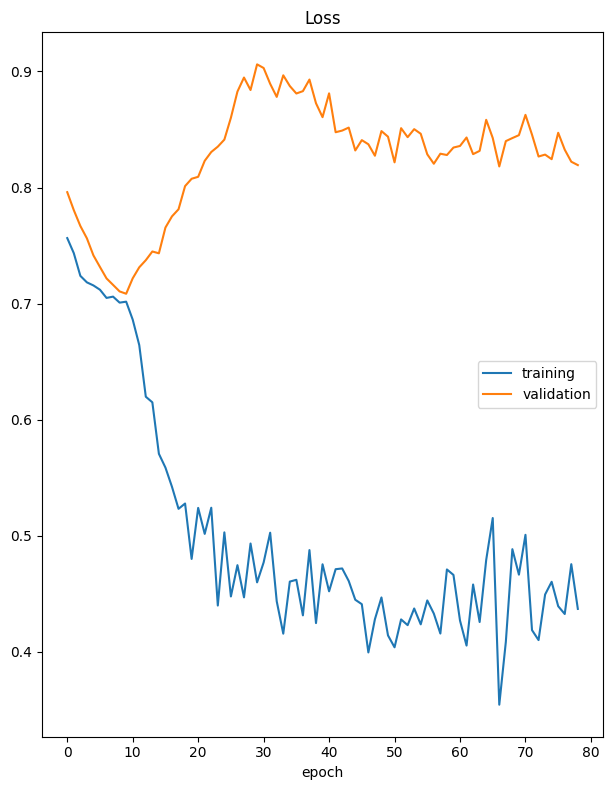

Loss
	training         	 (min:    0.354, max:    0.756, cur:    0.437)
	validation       	 (min:    0.708, max:    0.906, cur:    0.819)


In [8]:
# Create an instance of the CNN model
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.nn.functional as F

def custom_loss(logits, targets, penalty_weight=0.1):
    """
    Custom loss function that penalizes frequent changes in the prediction sequence.
    
    Args:
    - logits: Tensor of shape [N, C, L], where N is batch size, C is number of classes, and L is sequence length.
    - targets: Tensor of shape [N, L] containing class indices for each element in the sequence.
    - penalty_weight: Weight of the penalty term.

    Returns:
    - Total loss with the penalty.
    """

    # Standard cross-entropy loss
    ce_loss = F.cross_entropy(logits, targets)

    # Convert logits to one-hot probabilities and get the max probability index for each element
    probabilities = F.softmax(logits, dim=1)
    one_hot_predictions = torch.argmax(probabilities, dim=1)
    # Calculate changes between adjacent elements in the sequence
    product_prob = torch.prod(probabilities, dim=1)
    changes = torch.abs(one_hot_predictions[:, 1:] - one_hot_predictions[:, :-1]) * torch.abs(product_prob[:, 1:] - product_prob[:, :-1])
    
    # Sum the changes to get the penalty term
    penalty = changes.sum(dim=1).float().mean()
    # print(ce_loss, penalty.item())
    # Total loss
    total_loss = ce_loss#+ penalty

    return total_loss



model = SimpleSegmenterMaskTransformer().to(device)

# Define the loss function and optimizer
criterion =custom_loss #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
liveloss = PlotLosses()
# Iterate over the training data
logs = {}
# change the plt size:
best_loss = math.inf
counter_i = 0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Forward pass
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs.view(images.shape[0], 2, -1)
        loss = criterion(outputs, labels.long())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train loss and accuracy check:
        if counter_i % 1000 == 0 and counter_i != 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            _, predicted = torch.max(outputs.data, 1)
            # total = labels.size(0)
            # correct = (predicted == labels).sum().item()
            # print('Accuracy: {:.2f}%'.format(correct / total * 100))
            logs['loss'] = loss.item()
            # logs['accuracy'] = correct / total * 100
    
            # validation loss and accuracy check:
            correct = 0
            total = 0
            losses =  []
            for images, labels in val_loader:
                images = images.float().to(device)
                labels = labels.to(device)
                outputs = model(images)
                outputs = outputs.view(images.shape[0], 2, -1)
                loss = criterion(outputs, labels.long())
            logs['val_loss'] = loss.item()
            if best_loss > loss.item():
                best_loss = loss.item()
                torch.save(model.state_dict(), './saved_model/best_transformer_spar.pth')
            liveloss.update(logs)
            liveloss.send()
            # logs['val_accuracy'] = correct / total * 100
        counter_i += 1
    

# Evaluate the model on the test data
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for images, labels in test_loader:
#         images = images.float().to(device)
#         labels = labels.squeeze().long().to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
    
#     accuracy = 100 * correct / total
#     print('Test Accuracy: {:.2f}%'.format(accuracy))


In [9]:
import time
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
model = SimpleSegmenterMaskTransformer().to(device)
model.load_state_dict(torch.load('./saved_model/best_transformer_spar.pth'))

model.eval()
dice, total = 0, 0
with torch.no_grad():
    for data, label in test_loader:
        data = data.float().to(device)
        label = label.squeeze().long().to(device)
        output = model(data)
        output = output.view(data.shape[0], 2, -1)
        dice += dice_coefficient_time_series(output, label)
        total += 1
        output = output.argmax(dim=1)
        # print('output', output)])
        plt.plot(data[0].view(-1, 6).cpu().numpy(), color='black')
        plt.plot(output[0].view(-1).detach().squeeze().cpu().numpy()+1, color='green')
        plt.plot(label[0].view(-1).cpu().numpy(), color='red')
        plt.show()
        # wait for 1 sec:
        time.sleep(1)
        # erase the output:
        clear_output(wait=True)

print('Dice coefficient:', dice / total)

Dice coefficient: tensor(0.2451, device='cuda:1')


In [10]:
# few show learning on a new dataset:
directory = './datasets/physiq_copy/segment_sessions_one_repetition_data_E2'
combo = ['1', '2']
num_results = 1  # Number of random combinations to generate
files = list_files(directory)
groups = group_files(files)
# randomly pick one group from the dic:
key = random.choice(list(groups.keys()))
group = groups[key]
combinations,labels = generate_combinations(group, combo, num_results)
# print(combinations)


segmented_samples = []
segmented_labels = []
for i, (order, label) in enumerate(zip(combinations, labels)):
    print('length', len(order), order, label)
    concatenated_np, concat_label = concatenate_data(directory, group, order, label=label)
    
    conc_data = torch.tensor(concatenated_np)
    conc_label = torch.tensor(concat_label)
    
    segmented_sample, segmneted_label  = sw.forward(conc_data, conc_label)
    segmented_samples.append(segmented_sample)
    segmented_labels.append(segmneted_label)

segmented_samples = torch.cat(segmented_samples)
segmented_labels = torch.cat(segmented_labels)
support_Size = len(segmented_labels)
# change it to be dataset
dl = DataLoader(CustomDataset(segmented_samples, segmented_labels), batch_size=5, shuffle=False)

length 5 ['1', '2', '0', '0', '1'] [1, 1, 0, 0, 0]


NameError: name 'sw' is not defined

In [ ]:
# few show learning on a new dataset:
directory = './datasets/physiq_copy/segment_sessions_one_repetition_data_E2'
combo = ['1', '2']
num_results = 1  # Number of random combinations to generate
files = list_files(directory)
groups = group_files(files)
# randomly pick one group from the dic:
key = random.choice(list(groups.keys()))
group = groups[key]
combinations,labels = generate_combinations(group, combo, num_results)
# print(combinations)


segmented_samples = []
segmented_labels = []
for i, (order, label) in enumerate(zip(combinations, labels)):
    print('length', len(order), order, label)
    concatenated_np, concat_label = concatenate_data(directory, group, order, label=label)
    
    conc_data = torch.tensor(concatenated_np)
    conc_label = torch.tensor(concat_label)
    
    segmented_sample, segmneted_label  = sw.forward(conc_data, conc_label)
    segmented_samples.append(segmented_sample)
    segmented_labels.append(segmneted_label)

segmented_samples = torch.cat(segmented_samples)
segmented_labels = torch.cat(segmented_labels)

# change it to be dataset
test_dl = DataLoader(CustomDataset(segmented_samples, segmented_labels), batch_size=5, shuffle=False)

length 7 ['1', '1', '0', '1', '2', '1', '1'] [0, 0, 0, 1, 1, 0, 0]


In [ ]:
def cosine_distance_to_prototypes(A, B) -> torch.Tensor:
    """
    Compute prediction logits from their cosine distance to support set prototypes.
    Args:
        samples: features of the items to classify of shape (n_samples, feature_dimension)
    Returns:
        prediction logits of shape (n_samples, n_classes)
    """
    return torch.nn.functional.normalize(A, p=2, dim=1) @ torch.nn.functional.normalize(B, p=2, dim=1).T

def get_logits(features: torch.tensor, prototype, temperature=0.1) -> torch.tensor:

    """
    Computes the cosine similarity between self.prototype and given features
    inputs:
        features : shape [n_tasks, shot, c, h]

    returns :
        logits : shape [n_tasks, shot, h]
    """

    # Put prototypes and features in the right shape for multiplication
    features = features.permute((0, 1, 3, 2))  # [n_task, shot, h, c]
    print('features should n=N, shot=1, h=100, c=64', features.shape)
    prototype = prototype.unsqueeze(1).unsqueeze(2)  # [n_tasks, 1, 1, c]
    print('prototype = [n_tasks, 1, 1, c]', prototype.shape)
    print(prototype.shape)
    # Compute cosine similarity
    cossim = features.matmul(prototype.unsqueeze(3)).squeeze(3) # [n_task, shot, h=100, w]
    cossim /= ((prototype.unsqueeze(3).norm(dim=4) * \
                features.norm(dim=4)) + 1e-10)  # [n_tasks, shot, h, w]

    return temperature * cossim
    
def init_prototypes(features_s, features_q, support_labels, n_task=2, c=1):
    """
        inputs:
            n_task = N, shot = 1, c is the hidden feature (channel) = 64, h = 100
            features_s : shape [n_task, shot, c, h]
            features_q : shape [n_task, 1, c, h]
            gt_s : shape [n_task, shot, H]
            gt_q : shape [n_task, 1, H]

        returns :
            prototypes : shape [n_task, c]
            bias : shape [n_task]
    """
    # Computing prototypes
    fg_mask = (support_labels == 1)
    fg_mask = fg_mask.unsqueeze(1) # [n_task, shot=1, 100]
    print("fg_mask", fg_mask.shape)
    print("features_s", features_s.shape)
    fg_prototype = (features_s * fg_mask).sum(dim=1)
    fg_prototype /= (fg_mask.sum(dim=1) + 1e-10)  # [n_task, c]

    prototype = fg_prototype
    print('features_q, [n_tasks, 1, c, h]',features_q.shape)
    features_q = features_q.unsqueeze(1)  # [n_tasks, 1, c, h]
    logits_q = get_logits(features_q, prototype)  # [n_tasks, shot, h]
    bias = logits_q.mean(dim=(1, 2))

    assert prototype.size() == (n_task, c), prototype.size()
    assert torch.isnan(prototype).sum() == 0, prototype
    return 
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        
    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
        z_support = z_support.permute(0, 2, 1 )
        z_query = z_query.permute(0, 2, 1 )
        print(z_support.shape, z_query.shape, support_labels.shape)
        init_prototypes(z_support, z_query, support_labels)
        
    
    

In [ ]:
model.decoder = nn.Identity()
prototype_model = PrototypicalNetworks(model).to(device)

In [ ]:
sample = next(iter(dl))
test_sample = next(iter(test_dl))
print(sample[0].shape)
print(test_sample[0].shape)
z = prototype_model.forward(sample[0].float().to(device), sample[1].float().to(device), test_sample[0].float().to(device))
# z.shape

torch.Size([5, 75, 6])
torch.Size([5, 75, 6])
torch.Size([5, 64, 75]) torch.Size([5, 64, 75]) torch.Size([5, 75])
fg_mask torch.Size([5, 1, 75])
features_s torch.Size([5, 64, 75])
features_q, [n_tasks, 1, c, h] torch.Size([5, 64, 75])
features should n=N, shot=1, h=100, c=64 torch.Size([5, 1, 75, 64])
prototype = [n_tasks, 1, 1, c] torch.Size([5, 1, 1, 75])
torch.Size([5, 1, 1, 75])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [25, 64] but got: [25, 1].